Completed Sudoku Puzzles: https://www.kaggle.com/datasets/bryanpark/sudoku

In [26]:
import numpy as np

solutions_9by9 = np.zeros((10000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    if i >= solutions_9by9.shape[0]:
        break

    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        solutions_9by9[i, j] = s

solutions_9by9 = solutions_9by9.reshape((-1, 9, 9))

In [28]:
solutions_6by6 = solutions_9by9[:,:6,:6]

In [81]:
SIZE = 9

In [ ]:
if SIZE == 9:
    solutions = solutions_6by6
elif SIZE == 6:
    solutions = solutions_9b69

In [71]:
num_train = 10000

In [72]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import Flatten

import random

transform = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          Flatten(0)
                          ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
testset = datasets.MNIST('data', download=True, train=False, transform=transform)

train_ids = random.sample(range(0, 50000), num_train)

In [255]:
class SudokuDataset(Dataset):
    def __init__(self, dataset, digit_ids, solutions):
        self.dataset = dataset
        
        self.digit_to_id = {}

        for d in range(10):
            self.digit_to_id[d] = []

        for d_id in digit_ids:
            self.digit_to_id[dataset[d_id][1]].append(d_id)
    
        print('num digit_ids: ', len(digit_ids))
        print('solutions: ', len(solutions))
        
        
        self.solution_image_ids = torch.empty((solutions.shape[0],
                                               solutions.shape[1] ** 2), dtype=torch.int32) # n x 36 or 81
        for i, sol in enumerate(solutions):
            for j, digit in enumerate(sol.flatten()):
                self.solution_image_ids[i, j] = self.get_id_from_digit(digit)

    def get_id_from_digit(self, digit):
        return random.sample(self.digit_to_id[digit], 1)[0]
    
    def __len__(self):
        return self.solution_image_ids.shape[0]
    
    def __getitem__(self, idx):
        digit_ids = self.solution_image_ids[idx]
        
        images = torch.empty((self.solution_image_ids.shape[1], 28 * 28))
        labels = torch.empty((self.solution_image_ids.shape[1],))
        
        for i, d_id in enumerate(digit_ids):
            images[i] = self.dataset[d_id][0]
            labels[i] = self.dataset[d_id][1]
        
        images = torch.unsqueeze(images, dim=0)
        labels = torch.unsqueeze(labels, dim=0)
        
        return {'images': images, 'labels': labels}
    
s_data = SudokuDataset(trainset, train_ids, solutions[:1000])


num digit_ids:  10000
solutions:  1000


In [256]:
from matplotlib import pyplot as plt

def viz(images):
    plt.figure(figsize=(10, 10))
    
    fig, axes = plt.subplots(SIZE, SIZE)
    
    for ax, img in zip(axes.flatten(), images[0]):
        ax.imshow(img.reshape(28, 28))
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [257]:
s_data[0]['images'].shape

torch.Size([1, 81, 784])

<Figure size 720x720 with 0 Axes>

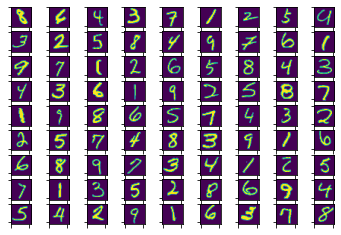

In [258]:
viz(s_data[0]['images'])

In [307]:
import sys
sys.path.append('../../')

import logging
logging.basicConfig(level=logging.INFO)

from regr.graph import Graph, Concept, Relation
from regr.graph.logicalConstrain import andL, existsL, notL, atMostL, ifL, fixedL, eqL, exactL
from regr.graph import EnumConcept
from regr.sensor.pytorch.sensors import JointSensor, ReaderSensor, FunctionalSensor
from regr.sensor.pytorch.learners import ModuleLearner

In [308]:
Graph.clear()
Concept.clear()
Relation.clear()

with Graph('global') as graph:
    sudoku = Concept("sodoku")
    
    empty_entry = Concept(name='empty_entry')
    (empty_rel, ) = sudoku.contains(empty_entry)
    
    same_row = Concept(name="same_row")
    (same_row_arg1, same_row_arg2) = same_row.has_a(row1=empty_entry, row2=empty_entry)
    
    same_col = Concept(name="same_col")
    (same_col_arg1, same_col_arg2) = same_col.has_a(col1=empty_entry, col2=empty_entry)
    
    same_table = Concept(name="same_table")
    (same_table_arg1, same_table_arg2) = same_table.has_a(table1=empty_entry, table2=empty_entry)
    
    empty_entry_label = empty_entry(name="empty_entry_label", ConceptClass=EnumConcept, 
                                    values=[f'v{d}' for d in range(SIZE)])
    v = [getattr(empty_entry_label, a) for a in ('', *empty_entry_label.enum)]

    for row_num in range(6):
        for j in range(1, 7):
            exactL(v[j](path = (eqL(empty_entry, "rows", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "cols", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "tables", {row_num}))))

/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('row1', 'empty_entry'), ('row2', 'empty_entry')]) is used.
  if sys.path[0] == '':
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('col1', 'empty_entry'), ('col2', 'empty_entry')]) is used.
  from ipykernel import kernelapp as app
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('table1', 'empty_entry'), ('table2', 'empty_entry')]) is used.


In [309]:
cols_indices = torch.arange(SIZE).repeat((SIZE, 1)).flatten()
rows_indices = torch.arange(SIZE).repeat((SIZE, 1)).T.flatten()
cols_indices = cols_indices.unsqueeze(-1) # 81 x 1
rows_indices = rows_indices.unsqueeze(-1) # 81 x 1

In [310]:
tables_indices = torch.empty((SIZE, SIZE))

for i in range(0, SIZE, 3):
    for j in range(0, SIZE, 3):
        tables_indices[i:i+3, j:j+3] = i + j//3

tables_indices = tables_indices.flatten().unsqueeze(-1) # 81 x 1

In [311]:
sudoku['images'] = ReaderSensor(keyword='images') # 1 x 81 x 784
sudoku['all_logits'] = ModuleLearner('images', module=Net()) # 1 x 81 x 128

sudoku['labels'] = ReaderSensor(keyword='labels') # 1 x 81

In [312]:
def unpack(logits, labels):
    return rows_indices, cols_indices, tables_indices, logits[0], labels[0], torch.ones((SIZE ** 2, 1))

In [313]:
empty_entry['rows', 'cols', 'tables', 'logits', 'label', empty_rel] = JointSensor(sudoku['all_logits'],
                                                                         sudoku['labels'],
                                                                         forward=unpack)

In [314]:
empty_entry[empty_entry_label] = FunctionalSensor('logits', forward=lambda x: x)

In [315]:
# sanity check
#empty_entry[empty_entry_label] = FunctionalSensor('label', forward=lambda x: torch.unsqueeze(x, dim=0), label=True)

In [316]:
from torch import nn

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.lin1 = nn.Linear(256, 128)
        self.lin2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.reshape(SIZE ** 2, 1, 28, 28)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.reshape(SIZE ** 2, -1)

        x = self.lin1(x)
        x = self.relu(x)

        x = self.drop(x)

        y_digit = self.lin2(x)

        return torch.unsqueeze(y_digit, dim=0)

In [317]:
from regr.program import SolverPOIProgram
from regr.program.metric import MacroAverageTracker
from regr.program.loss import NBCrossEntropyLoss

'''program = SolverPOIProgram(
        graph,
        poi=(sudoku, empty_entry, same_row, same_col, same_table),
        inferTypes=['local/argmax'],
        loss=MacroAverageTracker(NBCrossEntropyLoss()),
)'''

"program = SolverPOIProgram(\n        graph,\n        poi=(sudoku, empty_entry, same_row, same_col, same_table),\n        inferTypes=['local/argmax'],\n        loss=MacroAverageTracker(NBCrossEntropyLoss()),\n)"

In [322]:
from regr.program.lossprogram import SampleLossProgram, PrimalDualProgram
from regr.program.model.pytorch import SolverModel

class CallbackProgram(SampleLossProgram):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_train_epoch = []

    def call_epoch(self, name, dataset, epoch_fn, **kwargs):
        if name == 'Testing':
            for fn in self.after_train_epoch:
                fn(kwargs)
        else:
            super().call_epoch(name, dataset, epoch_fn, **kwargs)


program = CallbackProgram(graph, SolverModel,
                    poi=(images,),
                    inferTypes=['local/argmax'],
                    loss=MacroAverageTracker(NBCrossEntropyLoss()),
                    metric={},
                    sample=True,
                    sampleSize=20,
                    sampleGlobalLoss=True,
                    beta=50)


In [329]:
program.after_train_epoch = [post_epoch_metrics]

In [323]:
trainloader = DataLoader(
    s_data,
    shuffle=False
)

In [324]:
optim = lambda param: torch.optim.Adam(param, lr=0.05)

In [331]:
program.train(trainloader,
              train_epoch_num=10,
              Optim=optim,
              device='auto',
              test_every_epoch=True
             )

INFO:regr.program.program:Epoch: 1
INFO:regr.program.program:Training:
Epoch 1 Training: 100%|██████████| 1000/1000 [00:38<00:00, 26.24it/s]
INFO:regr.program.program: - Constraint loss:
INFO:regr.program.program:None
INFO:regr.program.program:Epoch: 2
INFO:regr.program.program:Training:
Epoch 2 Training: 100%|██████████| 1000/1000 [00:38<00:00, 25.76it/s]
INFO:regr.program.program: - Constraint loss:
INFO:regr.program.program:None
INFO:regr.program.program:Epoch: 3
INFO:regr.program.program:Training:
Epoch 3 Training: 100%|██████████| 1000/1000 [00:38<00:00, 25.78it/s]
INFO:regr.program.program: - Constraint loss:
INFO:regr.program.program:None
INFO:regr.program.program:Epoch: 4
INFO:regr.program.program:Training:
Epoch 4 Training: 100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]
INFO:regr.program.program: - Constraint loss:
INFO:regr.program.program:None
INFO:regr.program.program:Epoch: 5
INFO:regr.program.program:Training:
Epoch 5 Training: 100%|██████████| 1000/1000 [00:38<00:00

KeyboardInterrupt: 

In [328]:
def post_epoch_metrics(kwargs):
    get_classification_report(trainloader)

In [326]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

def get_classification_report(dataloader):
    preds_all = []
    labels_all = []

    for node in tqdm(program.populate(dataloader), total=len(dataloader)):
        node.inferLocal()

        preds = torch.empty((SIZE ** 2))
        labels = node.getAttribute('labels')

        for i, entry in enumerate(node.getChildDataNodes(conceptName=empty_entry)):
            entry_pred = torch.argmax(entry.getAttribute('<empty_entry_label>/local/argmax'), dim=0)

            preds[i] = entry_pred

        print(preds.reshape(SIZE, SIZE))

        print(labels.reshape(SIZE, SIZE))

        preds_all.extend(preds.tolist())
        labels_all.extend(labels.tolist()[0])

        print('\n\n')

    print(classification_report(labels_all, preds_all))

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[7., 7., 7., 4., 4., 7., 9., 7., 4.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [4., 4., 7., 7., 7., 7., 4., 9., 7.],
        [7., 4., 7., 7., 7., 7., 7., 7., 4.],
        [7., 7., 7., 7., 7., 4., 7., 7., 7.],
        [7., 4., 9., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [9., 7., 4., 7., 7., 7., 7., 4., 7.],
        [7., 7., 7., 7., 7., 7., 7., 4., 7.]])
tensor([[8., 6., 4., 3., 7., 1., 2., 5., 9.],
        [3., 2., 5., 8., 4., 9., 7., 6., 1.],
        [9., 7., 1., 2., 6., 5., 8., 4., 3.],
        [4., 3., 6., 1., 9., 2., 5., 8., 7.],
        [1., 9., 8., 6., 5., 7., 4., 3., 2.],
        [2., 5., 7., 4., 8., 3., 9., 1., 6.],
        [6., 8., 9., 7., 3., 4., 1., 2., 5.],
        [7., 1., 3., 5., 2., 8., 6., 9., 4.],
        [5., 4., 2., 9., 1., 6., 3., 7., 8.]])



tensor([[7., 7., 7., 7., 7., 7., 7., 9., 7.],
        [7., 4., 7., 7., 7., 4., 9., 7., 7.],
        [7., 7., 7., 7., 7., 7., 4., 9., 7.],
        [7., 7., 7., 7., 7., 

tensor([[7., 7., 7., 7., 7., 4., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 4., 7., 7.],
        [7., 7., 7., 7., 9., 7., 9., 7., 7.],
        [7., 4., 4., 7., 4., 4., 7., 4., 7.],
        [7., 7., 7., 7., 7., 7., 7., 4., 7.],
        [7., 4., 7., 7., 7., 7., 9., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 4., 7., 7., 7., 7., 7.]])
tensor([[9., 7., 4., 1., 8., 3., 6., 5., 2.],
        [6., 5., 1., 2., 7., 4., 3., 8., 9.],
        [2., 8., 3., 5., 9., 6., 7., 1., 4.],
        [1., 2., 9., 8., 3., 5., 4., 7., 6.],
        [7., 4., 6., 9., 1., 2., 5., 3., 8.],
        [8., 3., 5., 6., 4., 7., 9., 2., 1.],
        [5., 6., 8., 3., 2., 9., 1., 4., 7.],
        [3., 1., 7., 4., 6., 8., 2., 9., 5.],
        [4., 9., 2., 7., 5., 1., 8., 6., 3.]])



tensor([[7., 4., 7., 9., 7., 4., 7., 7., 7.],
        [7., 7., 4., 9., 7., 7., 4., 7., 7.],
        [7., 7., 7., 4., 9., 7., 7., 4., 9.],
        [7., 7., 7., 7., 7., 

tensor([[7., 7., 4., 7., 4., 4., 7., 7., 7.],
        [7., 7., 7., 7., 4., 7., 9., 4., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 9.],
        [7., 4., 7., 4., 7., 7., 7., 7., 4.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [4., 7., 7., 7., 7., 4., 7., 7., 7.],
        [4., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.]])
tensor([[9., 6., 7., 2., 5., 4., 3., 1., 8.],
        [1., 8., 4., 3., 7., 9., 5., 6., 2.],
        [2., 5., 3., 1., 8., 6., 9., 4., 7.],
        [6., 9., 1., 7., 4., 8., 2., 3., 5.],
        [8., 3., 5., 6., 2., 1., 7., 9., 4.],
        [7., 4., 2., 5., 9., 3., 6., 8., 1.],
        [3., 7., 6., 4., 1., 5., 8., 2., 9.],
        [4., 2., 8., 9., 6., 7., 1., 5., 3.],
        [5., 1., 9., 8., 3., 2., 4., 7., 6.]])



tensor([[7., 4., 7., 7., 4., 7., 7., 7., 7.],
        [7., 9., 7., 4., 7., 7., 4., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 

tensor([[7., 4., 7., 7., 7., 7., 9., 7., 7.],
        [9., 7., 7., 7., 4., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 4., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 4., 7.],
        [7., 7., 7., 7., 7., 4., 7., 7., 7.],
        [7., 7., 4., 7., 7., 9., 7., 7., 7.],
        [7., 7., 4., 4., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 4., 7., 7., 7.]])
tensor([[8., 3., 1., 2., 4., 5., 7., 9., 6.],
        [7., 2., 6., 3., 1., 9., 5., 4., 8.],
        [9., 5., 4., 7., 6., 8., 2., 3., 1.],
        [4., 1., 9., 8., 7., 2., 3., 6., 5.],
        [3., 6., 8., 4., 5., 1., 9., 7., 2.],
        [2., 7., 5., 6., 9., 3., 8., 1., 4.],
        [5., 8., 7., 1., 3., 4., 6., 2., 9.],
        [1., 9., 3., 5., 2., 6., 4., 8., 7.],
        [6., 4., 2., 9., 8., 7., 1., 5., 3.]])



tensor([[7., 7., 7., 7., 7., 4., 7., 7., 9.],
        [4., 7., 7., 9., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [4., 7., 9., 7., 7., 

tensor([[7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 4., 7., 7., 4.],
        [7., 7., 4., 7., 7., 7., 7., 7., 4.],
        [7., 7., 7., 4., 7., 9., 7., 7., 7.],
        [7., 4., 7., 7., 7., 4., 7., 9., 7.],
        [7., 4., 4., 7., 7., 7., 4., 4., 7.],
        [4., 7., 7., 7., 7., 7., 4., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 4., 7., 7., 4., 7., 7.]])
tensor([[7., 6., 1., 4., 9., 5., 8., 2., 3.],
        [2., 8., 4., 3., 6., 7., 1., 5., 9.],
        [9., 5., 3., 1., 2., 8., 4., 6., 7.],
        [6., 2., 5., 7., 8., 4., 9., 3., 1.],
        [1., 3., 8., 2., 5., 9., 6., 7., 4.],
        [4., 9., 7., 6., 3., 1., 5., 8., 2.],
        [3., 4., 6., 5., 1., 2., 7., 9., 8.],
        [5., 7., 9., 8., 4., 3., 2., 1., 6.],
        [8., 1., 2., 9., 7., 6., 3., 4., 5.]])



tensor([[7., 7., 7., 7., 7., 4., 7., 4., 7.],
        [7., 7., 7., 4., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 4., 7.],
        [7., 7., 4., 7., 4., 

tensor([[7., 7., 9., 7., 7., 7., 7., 7., 7.],
        [7., 4., 9., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 4., 9.],
        [4., 7., 7., 7., 4., 4., 7., 7., 7.],
        [4., 4., 7., 9., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 9., 7., 4., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 4.]])
tensor([[1., 2., 7., 3., 9., 8., 5., 4., 6.],
        [6., 5., 4., 1., 7., 2., 3., 9., 8.],
        [3., 9., 8., 5., 6., 4., 1., 7., 2.],
        [7., 6., 9., 8., 3., 1., 2., 5., 4.],
        [4., 8., 2., 6., 5., 9., 7., 3., 1.],
        [5., 3., 1., 4., 2., 7., 6., 8., 9.],
        [9., 1., 6., 7., 4., 5., 8., 2., 3.],
        [2., 7., 3., 9., 8., 6., 4., 1., 5.],
        [8., 4., 5., 2., 1., 3., 9., 6., 7.]])



tensor([[7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 2.],
        [7., 7., 7., 7., 7., 4., 7., 7., 7.],
        [7., 7., 7., 7., 7., 

tensor([[7., 7., 7., 7., 7., 7., 4., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 4., 7., 7., 7., 4., 7.],
        [7., 4., 4., 7., 9., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 9., 7., 7., 4.],
        [9., 7., 7., 7., 4., 7., 7., 7., 7.],
        [7., 4., 7., 4., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 4., 4., 7.],
        [7., 7., 9., 7., 7., 7., 7., 7., 7.]])
tensor([[5., 6., 2., 8., 3., 4., 7., 1., 9.],
        [3., 1., 4., 9., 6., 7., 2., 8., 5.],
        [7., 9., 8., 2., 1., 5., 4., 3., 6.],
        [9., 7., 3., 6., 5., 8., 1., 4., 2.],
        [1., 2., 6., 3., 4., 9., 8., 5., 7.],
        [4., 8., 5., 1., 7., 2., 9., 6., 3.],
        [6., 3., 9., 7., 8., 1., 5., 2., 4.],
        [2., 5., 1., 4., 9., 6., 3., 7., 8.],
        [8., 4., 7., 5., 2., 3., 6., 9., 1.]])



tensor([[7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 4., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 4., 

tensor([[7., 7., 7., 2., 7., 7., 7., 7., 4.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 4., 4., 7.],
        [7., 7., 7., 7., 4., 7., 7., 7., 7.],
        [7., 9., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 4., 7., 7.],
        [7., 4., 7., 7., 7., 7., 7., 7., 7.]])
tensor([[2., 6., 5., 7., 4., 8., 9., 1., 3.],
        [9., 4., 3., 6., 5., 1., 7., 2., 8.],
        [7., 1., 8., 2., 3., 9., 4., 5., 6.],
        [4., 5., 1., 8., 2., 6., 3., 7., 9.],
        [3., 9., 2., 4., 7., 5., 6., 8., 1.],
        [8., 7., 6., 9., 1., 3., 2., 4., 5.],
        [6., 8., 7., 5., 9., 4., 1., 3., 2.],
        [1., 2., 9., 3., 8., 7., 5., 6., 4.],
        [5., 3., 4., 1., 6., 2., 8., 9., 7.]])



tensor([[7., 7., 7., 4., 4., 7., 7., 9., 7.],
        [7., 7., 7., 7., 7., 7., 4., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 4.],
        [7., 7., 4., 7., 7., 

tensor([[4., 7., 7., 7., 7., 9., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 4., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 4., 7.],
        [7., 7., 7., 7., 7., 7., 9., 7., 7.],
        [4., 7., 7., 7., 7., 7., 7., 7., 7.],
        [7., 4., 7., 7., 7., 7., 7., 7., 7.],
        [7., 7., 7., 4., 7., 7., 7., 4., 7.]])
tensor([[3., 8., 1., 4., 5., 7., 6., 9., 2.],
        [9., 4., 2., 8., 6., 1., 3., 7., 5.],
        [6., 7., 5., 9., 3., 2., 1., 8., 4.],
        [1., 6., 3., 5., 7., 9., 4., 2., 8.],
        [7., 5., 4., 2., 8., 6., 9., 3., 1.],
        [8., 2., 9., 1., 4., 3., 5., 6., 7.],
        [4., 3., 7., 6., 1., 8., 2., 5., 9.],
        [5., 9., 6., 7., 2., 4., 8., 1., 3.],
        [2., 1., 8., 3., 9., 5., 7., 4., 6.]])



tensor([[7., 7., 7., 4., 7., 7., 7., 7., 7.],
        [7., 7., 7., 7., 7., 7., 7., 7., 9.],
        [7., 4., 7., 7., 4., 7., 7., 7., 7.],
        [7., 7., 9., 7., 7., 

KeyboardInterrupt: 